In [51]:
import numpy as np, torch, scipy.io as io, glob, os, OpenEXR, h5py, pathlib, cv2
import matplotlib.pyplot as plt, seaborn as sns, PIL.Image as Image
from matplotlib.ticker import FuncFormatter

from cleanplots import *
import plotly
import sys
sys.path.insert(0, "../..")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = "cuda:1"

import utils.helper_functions as helper
import utils.diffuser_utils as diffuser_utils
import dataset.preprocess_data as prep_data
import train

%load_ext autoreload
%autoreload 2

%matplotlib inline

SAVE_GT_PATH = "/home/cfoley/defocuscamdata/recons/sim_comparison_figure/model_input_gts"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# LOAD PREDICTIONS AND GROUND TRUTHS

In [14]:
names = ["harvard_bushes", "icvl_color_checker", "kaist_scene03", "fruit_artichoke"]

base_path = "/home/cfoley/defocuscamdata/recons/sim_comparison_figure/"
gt_path, fista_path, learned_path, handshake_path, diffuser_path = base_path + "model_input_gts", base_path + "fista_recons", base_path + "learned_recons", base_path + "handshake_recons", base_path + "diffuser_recons"

files = glob.glob(os.path.join(gt_path, "*.npy")) + glob.glob(os.path.join(learned_path, "*3meas.npy")) + glob.glob(os.path.join(fista_path,"*.npy"))+ glob.glob(os.path.join(handshake_path,"*.npy")) + glob.glob(os.path.join(diffuser_path,"*.npy"))

In [53]:
def draw_plot_marker(image, point, radius):
    im = np.copy(image)
    px, py = int(point[1]), int(point[0])

    cv2.circle(im, (px, py), radius, (255, 255, 255), -1)
    return im


def plot_vectors(npy_files: list, pointyx, model_names: list, spectral_range : tuple, color_idcs: list):
    linestyles = ["-", "--", "-.", ":", (0, (10, 3))]

    # Initialize empty lists to store data
    py, px = pointyx
    data, maxvals = [], []
    colors = sns.husl_palette(n_colors=10, l=0.5)
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.2)

    # Load data from npy files and append the specific point to the data list
    for i, file in enumerate(npy_files):
        hsimage = np.load(file)
        maxvals.append(np.max(hsimage))

        point = np.mean(helper.value_norm(hsimage)[py-3:py+3, px-3:px+3,:-1], axis=(0,1))
        data.append(point)

    wavs = np.linspace(spectral_range[0], spectral_range[1], len(data[0]))

    # Plotting
    plt.figure(dpi=100, figsize=(17,7))
    for i, d in enumerate(data):
        plt.plot(
            wavs,
            d / (max(maxvals) / maxvals[i]),
            color=colors[color_idcs[i]],
            label=model_names[i],
            linewidth=12,
            linestyle=linestyles[i]
        )

    def format_y_tick(value, pos):
        return '{:.1e}'.format(value)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_tick))
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_linewidth(7)
    plt.gca().spines["bottom"].set_linewidth(7)
    plt.gca().spines["left"].set_color("black")
    plt.gca().spines["bottom"].set_color("black")
    plt.xticks(fontsize=40)
    plt.yticks()
    #plt.legend(fontsize=50, framealpha=1)
    plt.show()

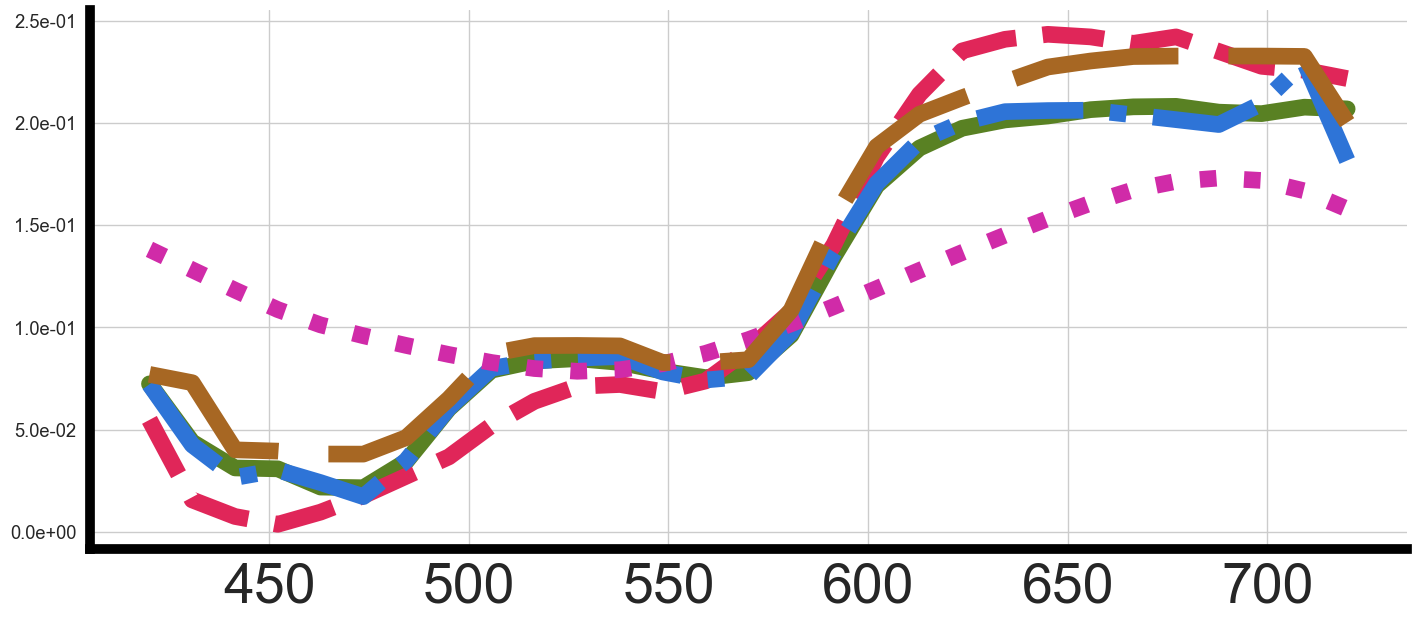

In [57]:
model_names = ["Reference", "Defocuscam (Learned)", "Defocuscam (Fista)", "DiffuserCam", "Handshake"]
color_idcs = [3, 0, 7, 9, 1]
kaist_range = (420, 720)
point = (201, 141)

plot_vectors([f for f in files if 'kaist' in f], point, model_names, kaist_range, color_idcs)

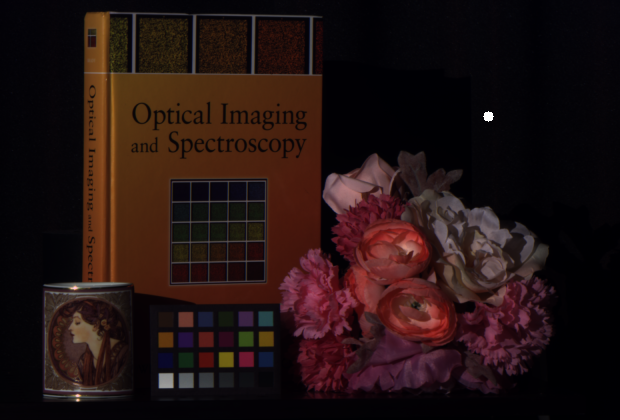

In [64]:
kaist_gt = np.load([f for f in files if 'kaist_scene03_gt' in f][0])
im = Image.fromarray(draw_plot_marker(helper.value_norm(helper.select_and_average_bands(kaist_gt, fc_range=kaist_range))*255, point, radius=5).astype(np.uint8))
im

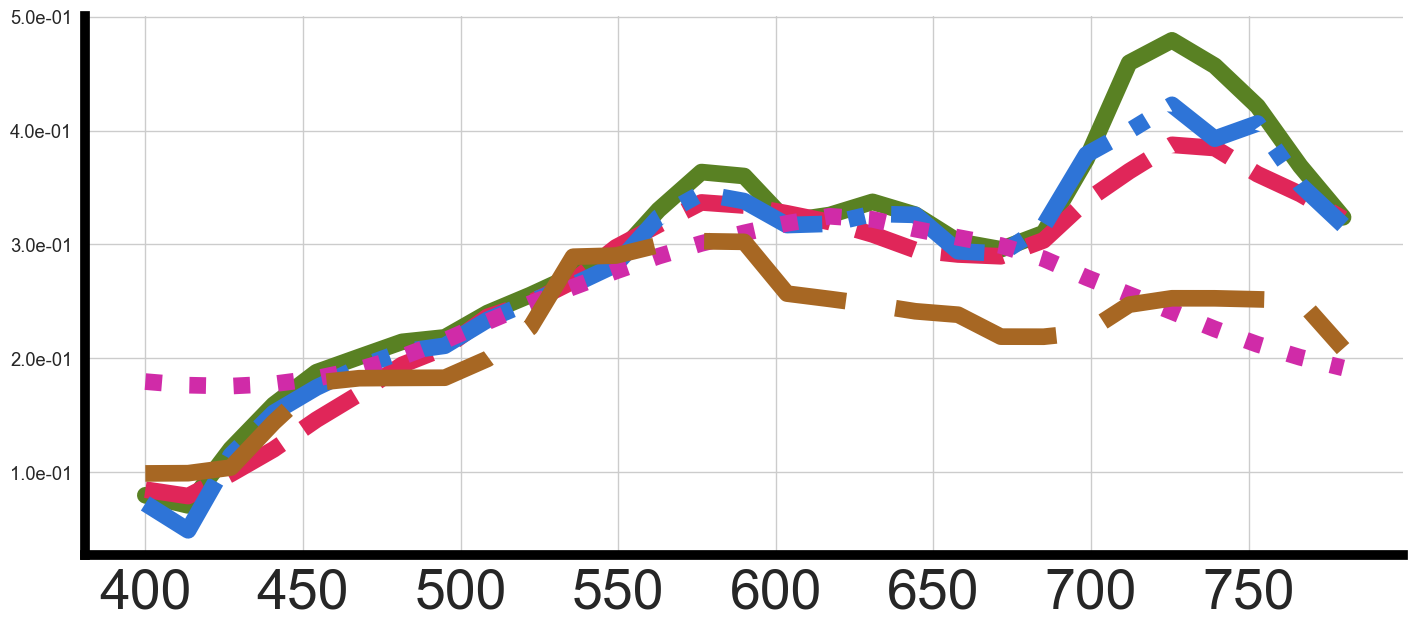

In [65]:
point = (116,488)
fruit_range = (400, 780)
plot_vectors([f for f in files if 'fruit' in f], point, model_names, fruit_range, color_idcs)

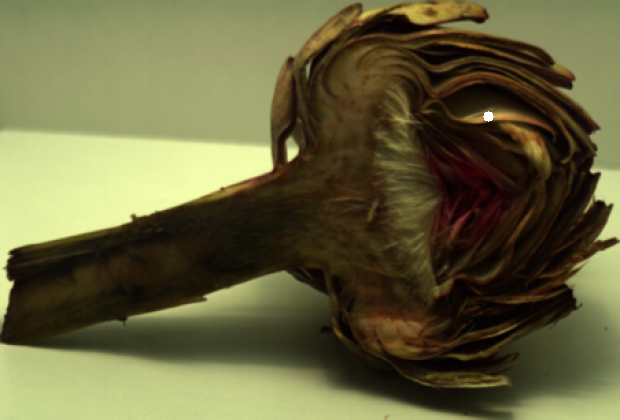

In [67]:
fruit_gt = np.load([f for f in files if 'fruit_artichoke_gt' in f][0])
im = Image.fromarray(draw_plot_marker(helper.value_norm(helper.select_and_average_bands(fruit_gt, fc_range=fruit_range))*255, point, radius=5).astype(np.uint8))
im

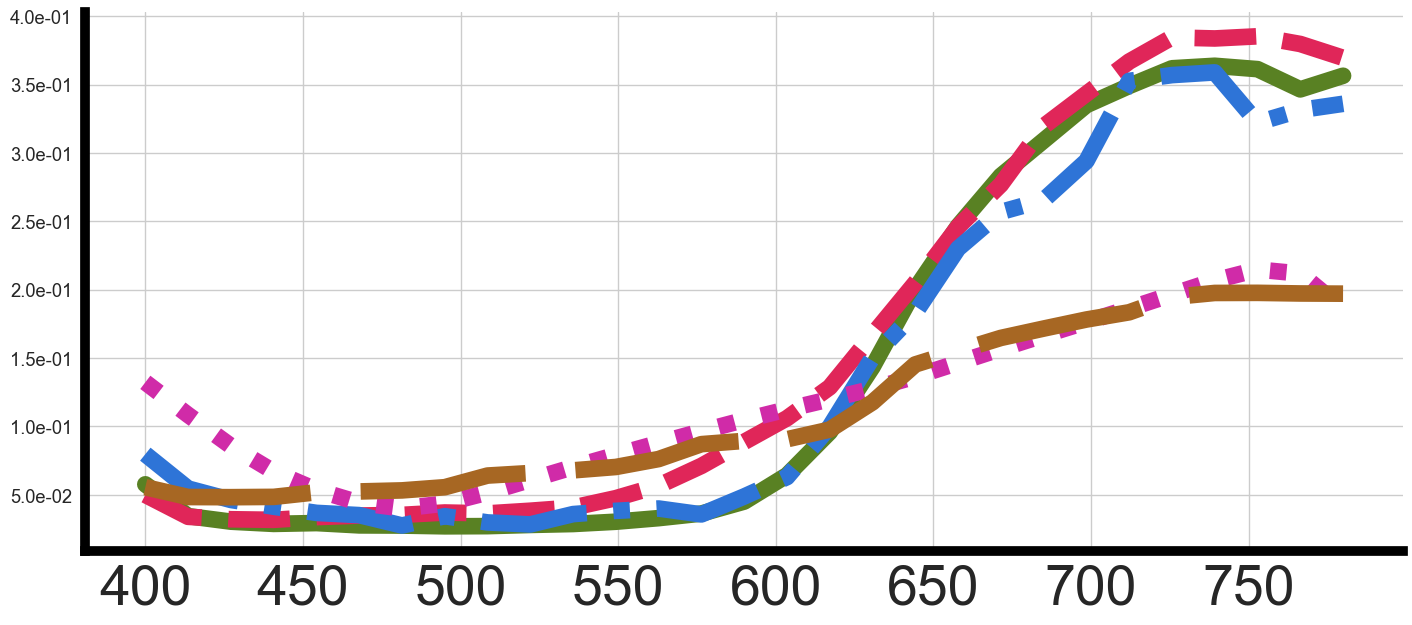

In [68]:
point = (216,522)
bushes_range = (420, 720)
plot_vectors([f for f in files if 'bushes' in f], point, model_names, fruit_range, color_idcs)

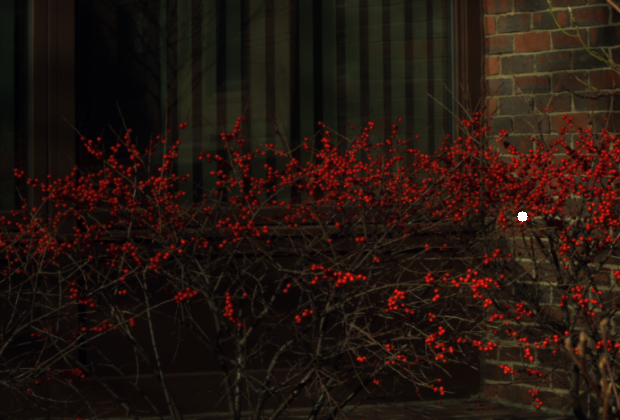

In [69]:
bushes_gt = np.load([f for f in files if 'harvard_bushes_gt' in f][0])
im = Image.fromarray(draw_plot_marker(helper.value_norm(helper.select_and_average_bands(bushes_gt, fc_range=bushes_range))*255, point, radius=5).astype(np.uint8))
im

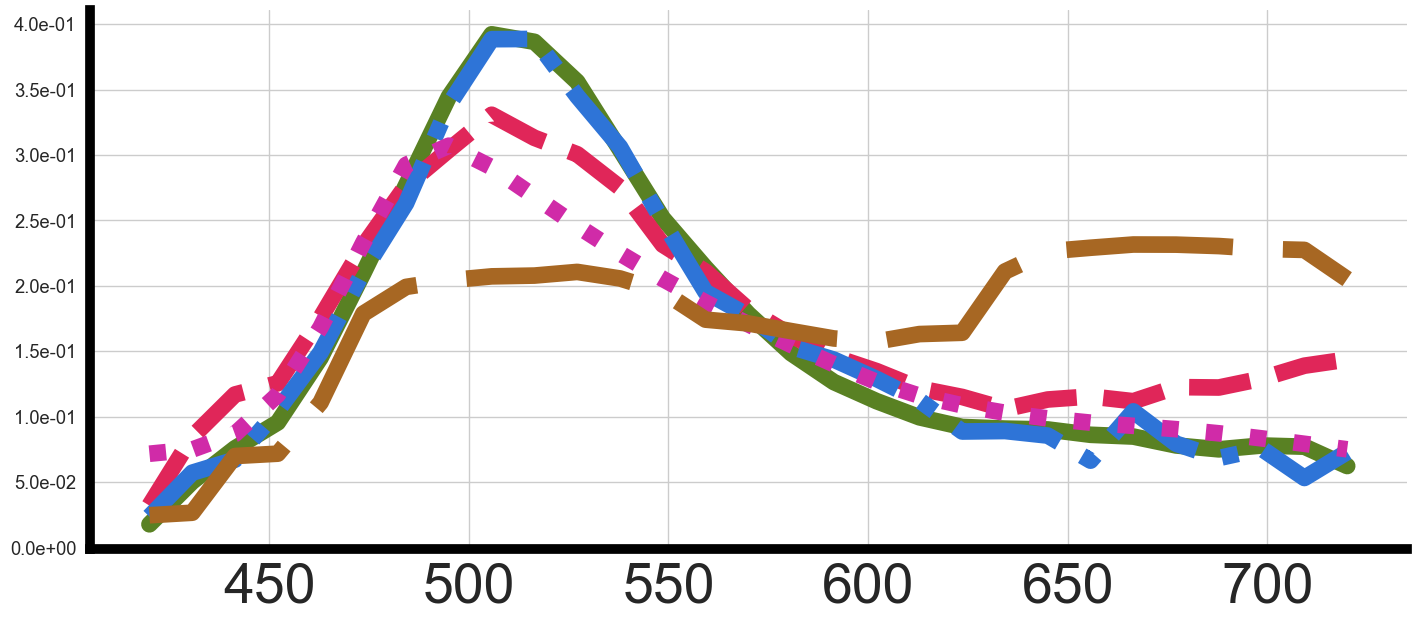

In [70]:
point = (219,249)
icvl_range = (420, 720)
plot_vectors([f for f in files if 'icvl_color' in f], point, model_names, icvl_range, color_idcs)

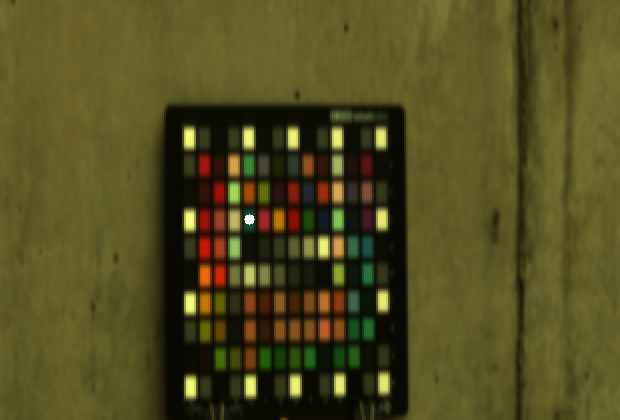

In [72]:
icvl_gt = np.load([f for f in files if 'icvl_color_checker_gt' in f][0])
im = Image.fromarray(draw_plot_marker(helper.value_norm(helper.select_and_average_bands(icvl_gt, fc_range=icvl_range))*255, point, radius=5).astype(np.uint8))
im